In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
import lime
from docx import Document
import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [11]:
df = pd.read_csv("../working_data/dataset.csv", index_col=0)

In [12]:
df = df[df["Category"] != "Industrial Crops"]

## Creating working data frame

In [13]:
#df['Year'] = pd.to_datetime(df['Year'], format='%Y')
#df.set_index("Year", inplace=True)
# getting list of names
categories = df["Category"].unique()

## Creating the metrics data frame

In [14]:
shap_df = pd.DataFrame()

In [15]:
def table_to_doc(df, cat):
    doc = Document()
    doc.add_table(df.shape[0]+1, df.shape[1]+1)
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            df[column] = df[column].astype(float)
            df[column] = df[column].round(4)
    # Write the column headers
    for i, column_name in enumerate(df.columns):
        doc.tables[0].cell(0, i+1).text = column_name

    # Write the DataFrame values and index
    for i, row in enumerate(df.iterrows()):
        doc.tables[0].cell(i+1, 0).text = str(row[0])
        for j, value in enumerate(row[1]):
            doc.tables[0].cell(i+1, j+1).text = str(value)

    doc.save(f'../tables/svr_lime_{cat}.docx') 

## Random Forest Regression

### Setting up dataframe

#### - Solving for stationarity

In [16]:
imputer = KNNImputer(n_neighbors=4)
adf_df = pd.DataFrame(columns=df.columns)

for cate in categories: 
    # Selects category
    crop_df = df[df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    # Selects column for ADF Test
    for col in num_cols:
        if crop_df[col].count() < 5:
            continue
        adf_result = adfuller(crop_df[col])
        while adf_result[1] > 0.05:
            crop_df[col] = crop_df[col].diff()
            crop_df[num_cols.columns] = imputer.fit_transform(crop_df[num_cols.columns])
            adf_result = adfuller(crop_df[col])

    adf_df = pd.concat([adf_df, crop_df])

#### - Transforming time series data to supervised learning (adding lags to variables)

In [17]:
main_df = pd.DataFrame(columns=adf_df.columns)
imputer = KNNImputer(n_neighbors=4)

# Sliding Window
for cate in categories: 
    # Selects category
    crop_df = adf_df[adf_df["Category"] == cate]
    num_cols = crop_df.select_dtypes(include=[np.number])
    for col in num_cols.columns:   
        for i in range(1, 3):
            crop_df[f'{col}-{i}'] = crop_df[col].shift(i)

    main_df = pd.concat([main_df, crop_df])
    num_cols = main_df.select_dtypes(include=[np.number])
    main_df[num_cols.columns] = imputer.fit_transform(main_df[num_cols.columns])

## Running the model

Intercept -24.67289522165314
Prediction_local [48.38219482]
Right: 82.18132400968746


,Features Vegetables and Legumes,Coeffcients - Vegetables and Legumes
0,Summer > 0.00,15.332832
1,Mean CO2 (ppm) <= 0.00,13.148721
2,Year-Round <= 0.00,12.809348
3,Mean CO2 (ppm)-2 <= 0.00,12.355120
4,Mean CO2 (ppm)-1 <= 0.00,7.219541
5,Fall <= 0.00,3.584705
6,Spring <= 0.00,3.048874
7,0.04 < Yield (tonnes/ha)-2 <= 0.20,2.402534
8,Yield (tonnes/ha)-1 > 0.35,1.815569
9,Ice > 0.00,1.337846


Intercept -1.3890312486661192
Prediction_local [0.63452625]
Right: 1.4160038307650868


,Features Cereals,Coeffcients - Cereals
0,Mean CO2 (ppm)-2 <= 0.00,1.723410
1,Summer <= 0.00,-1.158277
2,0.00 < Fall <= 1.00,0.668417
3,Mean CO2 (ppm) <= 0.00,0.435821
4,Mean CO2 (ppm)-1 <= 0.00,-0.386219
5,Ice-2 <= 0.50,0.184080
6,Tropical Nights-2 > 0.22,0.170085
7,Tornado <= 0.50,0.158971
8,Ice-1 <= 0.50,0.116554
9,Hail-2 <= 0.49,0.110716


Intercept 10.703681293224871
Prediction_local [9.94281535]
Right: 9.139688974227374


,Features Fruits and Nuts,Coeffcients - Fruits and Nuts
0,Mean CO2 (ppm) <= 0.00,-6.672562
1,Fall <= 0.00,5.442058
2,0.00 < Spring <= 1.00,-3.330372
3,Mean CO2 (ppm)-1 <= 0.00,1.761468
4,Tropical Nights-1 > 0.22,1.325945
5,Total-2 <= 0.48,1.027325
6,Devil-2 <= 0.50,-0.907402
7,Tornado-2 <= 0.50,-0.907316
8,Hot Days-2 <= 0.20,0.758650
9,Devil <= 0.50,0.741340


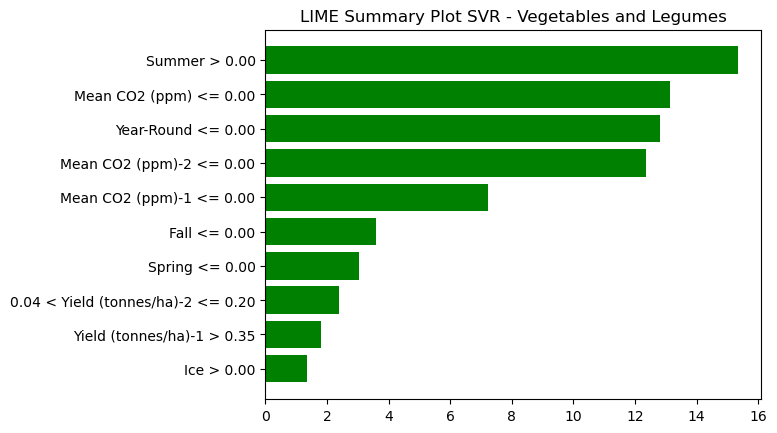

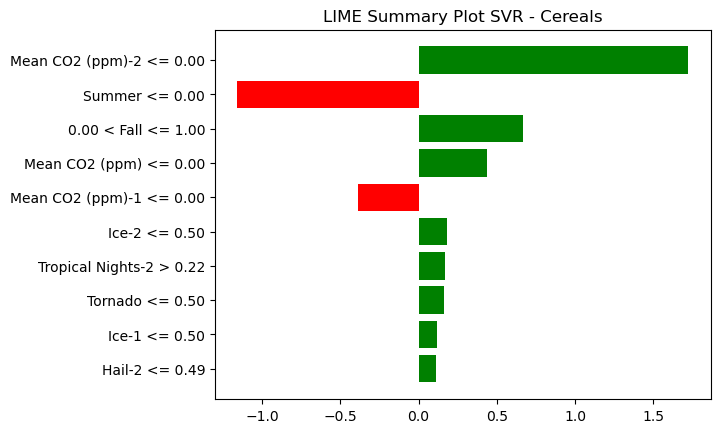

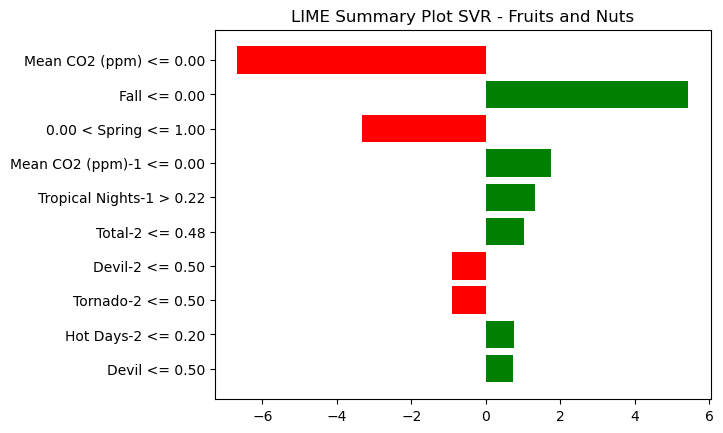

In [18]:
scaler = MinMaxScaler()
for cat in categories:
   crop_df = main_df[main_df['Category'] == cat]
   encoded_df = pd.get_dummies(crop_df[["Season"]], prefix='', prefix_sep='')
   encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)

   y = crop_df[['Yield (tonnes/ha)']]
   x = crop_df.drop(['Yield (tonnes/ha)', "Item", "Category", "Season"], axis=1)
   x = pd.concat([x, encoded_df], axis=1)

   mean = x.mean()
   std = x.std()
   lower_bound = mean - 2 * std
   upper_bound = mean + 2 * std
   x = x.clip(lower_bound, upper_bound, axis=1)

   x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
   
   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, random_state=42)
   regressor = SVR(kernel="rbf", C=100, epsilon=0.15)
   regressor.fit(x_train, y_train)
   
   #prediction of new value
   y_pred = regressor.predict(x_test)
   
   #lime implementation
   explainer = lime.lime_tabular.LimeTabularExplainer(np.array(x_train),
                  feature_names=x_train.columns, verbose=True,
                  class_names=['Yield(tonnes/ha)'], mode='regression')
   exp = explainer.explain_instance(x_test.iloc[-1], regressor.predict, num_features=10)

   exp.as_pyplot_figure()
   plt.title("LIME Summary Plot SVR - " + cat)
   
   lime_res = pd.DataFrame(exp.as_list(),  columns=['Features ' + cat, 'Coeffcients - ' + cat])
   display(lime_res)
   table_to_doc(lime_res, cat)